# Centroids version

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import local_binary_pattern
#from skimage.feature import hog


In [2]:
# Metaparameters
colorspace= 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient= 12
pix_per_cell= 4
cell_per_block= 1 #2
hog_channel= 'ALL' # Can be 0, 1, 2, or "ALL"


In [3]:
# Customized re-implementation of HOG, based on OpenCV and scikit-image versions
def histoGrad(img, binCount=12, cellSize=4):
    gx,gy= cv2.Sobel(img,cv2.CV_32F,1,0), cv2.Sobel(img,cv2.CV_32F,0,1) # gradients in x and y direction
    magnitude,angle= cv2.cartToPolar(gx,gy)
    bins= np.int32(binCount*angle*(1-1e-7)/(2*np.pi)) #scale back angle to avoid overbinning
    binCells,magCells= [],[]
    cx= cy= cellSize
    for i in range(0,int(img.shape[0]/cy)): # sort into bins
        for j in range(0,int(img.shape[1]/cx)):
            binCells.append(bins[i*cy:i*cy+cy, j*cx:j*cx+cx])
            magCells.append(magnitude[i*cy:i*cy+cy, j*cx:j*cx+cx])
    hist= np.hstack([np.bincount(i.ravel(), j.ravel(), binCount) for i,j in zip(binCells, magCells)])
    return np.sqrt(hist/(hist.sum()+1e-8)) # apply Hellinger kernel (L1-normalize and sqrt)

In [4]:
# Define a function to return HOG features
def get_hog_features(img, orient, pix_per_cell):
    features= histoGrad( img, orient, pix_per_cell )
    return features.reshape((192,))

# Define a function to return LBP features
def get_lpb_features(img):
    lbp= np.ravel(local_binary_pattern(img, 16, 2, method='uniform'))
    #print(lbp.shape)
    return lbp



In [5]:
#from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cells=True, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features= []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image= mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        if cells: # Already sized at 16x16 cells
            if hog_channel == 'ALL':
                hog_features= []
                for channel in range(feature_image.shape[2]):
                    #hog_features.append(get_hog_features(feature_image[:,:,channel], 
                    #                    orient, pix_per_cell, cell_per_block, 
                    #                    vis=False, feature_vec=True))
                    
                    # Attempt to train on gradient AND smaller color patch
                    hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], orient, pix_per_cell), 
                        np.ravel(cv2.resize(feature_image[:,:,channel], (4,4), interpolation=3) ) ))) #CV_INTER_AREA
                    #hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], 
                    #                    orient, pix_per_cell, cell_per_block, 
                    #                    vis=False, feature_vec=True), get_lpb_features(feature_image[:,:,channel]))))
                    #hog_features.append(feature_image[:,:,channel])
                hog_features= np.ravel(hog_features)        
            else:
                hog_features= get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell)
            # Append the new feature vector to the features list
            features.append(hog_features)
            
        else:
            #first, slice the 64x64 image into quads by column
            quad= []
            quad.append(feature_image[:, 0:16,:])
            quad.append(feature_image[:,16:32,:])
            quad.append(feature_image[:,32:48,:])
            quad.append(feature_image[:,48:64,:])
            for i in range(4):
                #next, slice the quad into cells(16x16) by row
                square= []
                square.append(quad[i][ 0:16,:,:])
                square.append(quad[i][16:32,:,:])
                square.append(quad[i][32:48,:,:])
                square.append(quad[i][48:64,:,:])
                for j in range(4):
                    feature_image= square[j]
                    # Call get_hog_features() with vis=False, feature_vec=True
                    if hog_channel == 'ALL':
                        hog_features = []
                        for channel in range(feature_image.shape[2]):
                            #hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            #                    orient, pix_per_cell, cell_per_block, 
                            #                    vis=False, feature_vec=True))
                            
                            # Attempt to train on gradient AND smaller color patch
                            hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], orient, pix_per_cell), 
                                np.ravel(cv2.resize(feature_image[:,:,channel], (4,4), interpolation=3) ) ))) #CV_INTER_AREA
                            #hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], 
                            #                    orient, pix_per_cell, cell_per_block, 
                            #                    vis=False, feature_vec=True), get_lpb_features(feature_image[:,:,channel]))))
                            #hog_features.append(feature_image[:,:,channel])
                        hog_features = np.ravel(hog_features)        
                    else:
                        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell)
                    # Append the new feature vector to the features list
                    features.append(hog_features)
            del quad, square
    # Return list of feature vectors
    return features

# load filenames of images containing vehicles
cars = []
vimages = glob.glob('training/vehicles/JWD_vcells/*.png')
for image in vimages:
    cars.append(image)

# load filenames of images containing non-vehicles
nimages = glob.glob('training/non-vehicles/Extras/*.png')
notcars = []
for image in nimages:
    notcars.append(image)

del vimages, nimages
# Reduce the sample size because HOG features are slow to compute
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print('Step complete.')

Step complete.


In [6]:
# Load data from files into training arrays
t=time.time()
print('Extracting cells of cars...')
car_features= extract_features(cars, cells=True, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print('Extracting notcars images...')
notcar_features= extract_features(notcars, cells=False, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# load additional cells containing non-vehicles
nimages= glob.glob('training/non-vehicles/JWD_ncells/*.png')
notcars= []
for image in nimages:
    notcars.append(image)
print('Extracting cells of notcars...')
notcarcell_features= extract_features(notcars, cells=True, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
del nimages

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

print(np.array(car_features).shape, np.array(notcar_features).shape, np.array(notcarcell_features).shape)
# Create an array stack of feature vectors
X= np.vstack((car_features, notcar_features, notcarcell_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler= StandardScaler().fit(X)
# Apply the scaler to X
scaled_X= X_scaler.transform(X)
print('Updating scaler.dat')
joblib.dump(X_scaler, 'scalar.dat')  # save for later use by classifier

# Define the labels vector
y= np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)), np.zeros(len(notcarcell_features))))

# Split up data into randomized training and test sets
rand_state= np.random.randint(0, 100)
X_train, X_test, y_train, y_test= train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

del scaled_X, y, cars, notcars
del car_features, notcar_features, notcarcell_features
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Extracting cells of cars...
Extracting notcars images...
Extracting cells of notcars...
29.86 Seconds to extract HOG features...
(2702, 624) (15488, 624) (3510, 624)
Updating scaler.dat
Using: 12 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 624


In [152]:
# Define a linear SVC (CPU-based)
#svc = LinearSVC()
from sklearn import svm
svc = svm.SVC(kernel='poly', gamma=2)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('   The SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

590.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9549
   The SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
0.1115 Seconds to predict 10 labels with SVC


In [7]:
# Define a non-linear binary classification model using Keras on TensorFlow

#####################################################################################################################
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

#model= Sequential([
#    Dense(1296, input_dim=len(X_train[0]), init='normal', activation='relu'),
#    Dropout(.5),
#    Dense(1, init='normal', activation='sigmoid')
#])

#model= Sequential([
#    Dropout(.5, input_shape=(len(X_train[0]),) ),
#    Dense(512, init='normal', activation='relu'),
#    Dropout(.5),
#    Dense(1, init='normal', activation='sigmoid')
#])
model= Sequential([
    Dropout(.5, input_shape=(len(X_train[0]),) ),
    Dense(255, init='normal', activation='relu'),
    Dropout(.5),
    Dense(127, init='normal', activation='relu'),
    Dropout(.5),
    Dense(1, init='normal', activation='sigmoid')
])


# binary classification
model.compile(optimizer='adam',  #rmsprop
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_1 (Dropout)              (None, 624)           0           dropout_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 255)           159375      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 255)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 127)           32512       dropout_2[0][0]                  
___________________________________________________________________________________________

In [8]:
# Check the training time for the GPU-based model
t=time.time()
model.fit(X_train, y_train, nb_epoch=35, batch_size=32, shuffle=True, verbose=2)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Net...')
# Check the score of the Net
print('Test Accuracy of Net = ', round(model.evaluate(X_test, y_test, batch_size=16)[1], 4))


Epoch 1/35
7s - loss: 0.2833 - acc: 0.8918
Epoch 2/35
5s - loss: 0.1920 - acc: 0.9246
Epoch 3/35
5s - loss: 0.1569 - acc: 0.9414
Epoch 4/35
4s - loss: 0.1384 - acc: 0.9481
Epoch 5/35
5s - loss: 0.1270 - acc: 0.9537
Epoch 6/35
5s - loss: 0.1143 - acc: 0.9589
Epoch 7/35
5s - loss: 0.1083 - acc: 0.9616
Epoch 8/35
5s - loss: 0.0959 - acc: 0.9647
Epoch 9/35
5s - loss: 0.0901 - acc: 0.9672
Epoch 10/35
4s - loss: 0.0886 - acc: 0.9685
Epoch 11/35
5s - loss: 0.0838 - acc: 0.9699
Epoch 12/35
5s - loss: 0.0777 - acc: 0.9727
Epoch 13/35
4s - loss: 0.0792 - acc: 0.9725
Epoch 14/35
4s - loss: 0.0748 - acc: 0.9737
Epoch 15/35
4s - loss: 0.0742 - acc: 0.9740
Epoch 16/35
4s - loss: 0.0719 - acc: 0.9742
Epoch 17/35
4s - loss: 0.0692 - acc: 0.9748
Epoch 18/35
4s - loss: 0.0660 - acc: 0.9769
Epoch 19/35
4s - loss: 0.0602 - acc: 0.9791
Epoch 20/35
4s - loss: 0.0672 - acc: 0.9775
Epoch 21/35
4s - loss: 0.0607 - acc: 0.9782
Epoch 22/35
4s - loss: 0.0621 - acc: 0.9786
Epoch 23/35
4s - loss: 0.0619 - acc: 0.97

In [13]:
# Run additional training epochs (if necessary)
t=time.time()
model.fit(X_train, y_train, nb_epoch=14, batch_size=32, shuffle=True, verbose=2)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Net...')
print('Test Accuracy of Net = ', round(model.evaluate(X_test, y_test, batch_size=16, verbose=1)[1], 4))


Epoch 1/14
4s - loss: 0.0448 - acc: 0.9856
Epoch 2/14
4s - loss: 0.0427 - acc: 0.9874
Epoch 3/14
4s - loss: 0.0423 - acc: 0.9857
Epoch 4/14
4s - loss: 0.0396 - acc: 0.9870
Epoch 5/14
5s - loss: 0.0384 - acc: 0.9869
Epoch 6/14
5s - loss: 0.0370 - acc: 0.9882
Epoch 7/14
4s - loss: 0.0429 - acc: 0.9864
Epoch 8/14
4s - loss: 0.0416 - acc: 0.9867
Epoch 9/14
4s - loss: 0.0373 - acc: 0.9874
Epoch 10/14
4s - loss: 0.0353 - acc: 0.9878
Epoch 11/14
5s - loss: 0.0407 - acc: 0.9867
Epoch 12/14
4s - loss: 0.0377 - acc: 0.9875
Epoch 13/14
4s - loss: 0.0431 - acc: 0.9866
Epoch 14/14
4s - loss: 0.0369 - acc: 0.9883
67.98 Seconds to train Net...
2032/2042 [============================>.] - ETA: 0s

In [26]:
print('Test Accuracy of Net = ', round(model.evaluate(X_test, y_test, batch_size=16, verbose=1)[1], 4))

2016/2042 [============================>.] - ETA: 0s  48/2042 [..............................] - ETA: 0s

In [9]:
# Finish training with test data
t=time.time()
model.fit(X_test, y_test, nb_epoch=21, batch_size=32, shuffle=True, verbose=2)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Net...')
# Check the score of the Net
print('Test Accuracy of Net = ', round(model.evaluate(X_test, y_test, batch_size=16, verbose=1)[1], 4))


Epoch 1/21
0s - loss: 0.0829 - acc: 0.9719
Epoch 2/21
0s - loss: 0.0787 - acc: 0.9747
Epoch 3/21
0s - loss: 0.0676 - acc: 0.9770
Epoch 4/21
0s - loss: 0.0539 - acc: 0.9820
Epoch 5/21
0s - loss: 0.0500 - acc: 0.9843
Epoch 6/21
0s - loss: 0.0598 - acc: 0.9816
Epoch 7/21
0s - loss: 0.0385 - acc: 0.9857
Epoch 8/21
0s - loss: 0.0503 - acc: 0.9816
Epoch 9/21
0s - loss: 0.0344 - acc: 0.9880
Epoch 10/21
0s - loss: 0.0410 - acc: 0.9843
Epoch 11/21
0s - loss: 0.0471 - acc: 0.9839
Epoch 12/21
0s - loss: 0.0271 - acc: 0.9899
Epoch 13/21
0s - loss: 0.0390 - acc: 0.9862
Epoch 14/21
0s - loss: 0.0423 - acc: 0.9880
Epoch 15/21
0s - loss: 0.0353 - acc: 0.9885
Epoch 16/21
0s - loss: 0.0371 - acc: 0.9889
Epoch 17/21
0s - loss: 0.0289 - acc: 0.9876
Epoch 18/21
0s - loss: 0.0400 - acc: 0.9862
Epoch 19/21
0s - loss: 0.0309 - acc: 0.9903
Epoch 20/21
0s - loss: 0.0309 - acc: 0.9894
Epoch 21/21
0s - loss: 0.0274 - acc: 0.9899
12.77 Seconds to train Net...
2144/2170 [============================>.] - ETA: 0s

In [10]:
# Save the model

import os
import json
import errno

def deleteFile(file):
    try:
        os.remove(file)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise


# Save the model and weights
deleteFile('model.json')
deleteFile('model.h5')
jsonString = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(jsonString, outfile)
model.save_weights('model.h5')


In [11]:
del X_train, X_test, y_train, y_test

In [50]:

del model

In [5]:
# Load binary classifier model

model= None
import json
from keras.models import model_from_json
with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read()))
model.compile("adam", "binary_crossentropy")
#weights_file = args.model.replace('json', 'h5')
model.load_weights('model.h5')
model.summary()
from sklearn.externals import joblib
X_scaler= joblib.load('scalar.dat')


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_1 (Dropout)              (None, 624)           0           dropout_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 255)           159375      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 255)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 127)           32512       dropout_2[0][0]                  
___________________________________________________________________________________________

In [12]:
def getFeaturesFromColorPatch(patch, orient=12, pix_per_cell=4, cell_per_block=1):
    global firstTime
    hog_features = []
    feature_patch= cv2.cvtColor(patch, cv2.COLOR_RGB2YCrCb)
    for channel in range(feature_patch.shape[2]):
        #hog_features.append(get_hog_features(feature_patch[:,:,channel], 
        #                    orient, pix_per_cell, cell_per_block, 
        #                    vis=False, feature_vec=True))
        
        # Compute gradient AND small color patch (note: color scaling)
        hog_features.append(np.concatenate((get_hog_features(feature_patch[:,:,channel], orient, pix_per_cell), 
            np.ravel(cv2.resize(feature_patch[:,:,channel], (4,4), interpolation=3) )/255. ))) #CV_INTER_AREA
        #hog_features.append(np.concatenate((get_hog_features(feature_patch[:,:,channel], 
        #                    orient, pix_per_cell, cell_per_block, 
        #                    vis=False, feature_vec=True), get_lpb_features(feature_patch[:,:,channel]))))
        #hog_features.append(np.zeros(432))   # <--- short out
    return np.ravel(hog_features)

def scalePatch(patch):
    global X_scaler # use previously defined scaler
    X= patch.astype(np.float64).reshape((1, -1))                       
    # Apply the scaler to X
    return np.array(X_scaler.transform(X))

#_______________________________________________________________________________
# Circular queuing class made with Numpy

class NQ():
    def __init__(self,qlen,shape,dtype=np.uint8):
        self.data= np.empty(shape=shape,dtype=dtype)
        self.qlen= qlen
    def put(self,a):
        self.data= np.append(self.data,a, axis=0)
        if len(self.data)>self.qlen: self.drop()
    def peek(self):
        return self.data[len(self.data)-1]
    def drop(self):
        self.data= np.delete(self.data, 0, axis=0)
    def getAvg(self):
        newList= np.copy(self.data[0])
        newList[:]= np.sum(self.data[:], axis=0)/float(len(self.data))
        return newList

def renderRig(img, cx,cy, width,height, clr, strokeWeight):
    pts=np.array([[0.75,0.1275], [0.4866666667,0.085], [0.286666667,0.1025], [0,0.3875], [0,0.645], [0.47,0.9275], [1,0.8825], [1,0.38]])
    pts[:,0]= pts[:,0]*width  + cx-width //2
    pts[:,1]= pts[:,1]*height + cy-height//2
    cv2.polylines(img, [pts.astype(np.int32)], True, clr, strokeWeight)

x= np.linspace(0, 14, 15)
y=np.array([766,780,796,814,834,857,882,910,941,976,1014,1057,1103,1155,1214])
coefs1= np.polyfit(x,y,3)
y=np.array([411,410,410,409,409,408,407,406,406,405,403,402,401,398,397])
coefs2= np.polyfit(x,y,2)
y=np.array([14,16,18,20,23,25,28,31,35,38,43,46,52,59,66])
coefs3= np.polyfit(x,y,2)
def transformIdxToScreen(idxFloat):
    global coefs1, coefs2, coefs3
    f1= np.poly1d(coefs1)
    f2= np.poly1d(coefs2)
    f3= np.poly1d(coefs3)
    return f1(idxFloat), f2(idxFloat), f3(idxFloat)

In [14]:
# Batch version
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg

def resizePatch(img):
    if len(img[0]) != 16:
        if len(img[0])>16:
            patch= cv2.resize(img, (16,16), interpolation=3) #CV_INTER_AREA
        else:
            patch= cv2.resize(img, (16,16), interpolation=2) #CV_INTER_CUBIC
    else:
        patch= img
    return patch

def preparePatch(p):
    patch= resizePatch(p)
    fpatch= getFeaturesFromColorPatch(patch)
    spatch= scalePatch(fpatch)
    return spatch

diagScreen= None
imgGlobal= None
patchBatch= [[], [], [], [], []]  # patch, x, y, s, prediction
predictionBatch= []

def addPatch(p,x,y,s):
    global patchBatch
    patchBatch[0].append(p)
    patchBatch[1].append(x)
    patchBatch[2].append(y)
    patchBatch[3].append(s)

def processStripB(x,y,s):
    global frameCount, imgGlobal
    for i in range(4):
        addPatch(imgGlobal[y:y+s, x:x+s, :],x,y,s)
        y= y+s

def processStripC(i):
    global frameCount, imgGlobal
    x,y,s= transformIdxToScreen(i)
    for i in range(4):
        addPatch(imgGlobal[y:y+s, x:x+s, :],x,y,s)
        y= y+s

# Predominant color assessment
def dominantWhite(img): 
    return (img>90).sum() > (img<=90).sum()

def locateCentroid(twoDimArray, prevCenterTuple):
    global frameCount
    #lst= [ [0,0,0,0,0,0,1,1,1,0,1,0,0,0,1],
    #   [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
    #   [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
    #   [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
    #mask= np.zeros_like(lst)
    mask= np.zeros((4,15),dtype=np.int32)
    #mask= np.copy( np.zeros_like(twoDimArray, dtype=np.uint8) )
    cv2.ellipse(mask, (prevCenterTuple, (7,4),0), 1,-1)
    mask= np.array(mask, dtype=np.uint8)
    masked= cv2.bitwise_and(mask, twoDimArray)
    m= cv2.moments(np.array(masked),True)
    return m['m10']/m['m00'], m['m01']/m['m00'] #return centroid float: x,y or col,row

prevCentroid= (17.,2.)
centroidQ= NQ(25, (0,2), np.int)
for i in range(25): # bias average to offscreen 
    centroidQ.put([ np.array([1400,529]) ])
lastDiagScreen= None
rx= 0
ry= 0
rs= 0

def processBatch(baseImage): # send the batch to the GPU for predictions
    global frameCount, patchBatch, predictionBatch, diagScreen, prevCentroid, lastDiagScreen
    global rx,ry,rs
    prepBatch= []
    for i in range( len(patchBatch[0]) ):
        prepBatch.append( preparePatch(patchBatch[0][i]) )
    predictionResults= model.predict( np.array(prepBatch).reshape((60,-1)) )
    patchBatch[4]= np.array(predictionResults>0.9,dtype=np.uint8)
    whiteCarFoundMaybe= False
    for i in range( len(patchBatch[4]) ):
        x= patchBatch[1][i]
        y= patchBatch[2][i]
        s= patchBatch[3][i]
        if patchBatch[4][i]:
            if dominantWhite(patchBatch[0][i]):
                diagScreen[y:y+s-1, x:x+s-1, 0]= 63 # red
                diagScreen[y:y+s-1, x:x+s-1, 1]= 31 # green
                if whiteCarFoundMaybe==False:
                    whiteCarFoundMaybe= True
                    whiteCarLoc= i
            else:
                diagScreen[y:y+s-1, x:x+s-1, 1]= 63 # green
    #    else:
    #        diagScreen[y:y+s-1, x:x+s-1, 0]= 63   #157  Red
        # More training data
        #if predictionResults[i]<0.9 and predictionResults[i]>0.4:
        #    mpimg.imsave('output_images/cells/'+str(frameCount)+'-'+str(x)+'-'+str(y)+'.PNG',resizePatch(patchBatch[0][i]))
    #Search the neighbors of the white car in all directions
    if whiteCarFoundMaybe:
        refM= np.array(patchBatch[4].reshape((4,15),order='F'), dtype=np.uint8) # reference data matrix
        whiteCarLeft= 0 # assume maxes
        whiteCarRight= 14
        whiteCarTop= 0
        whiteCarBottom= 3
#        if whiteCarLoc>4 and whiteCarLoc<56 and predictionBatch[i+4]>0.5 and predictionBatch[i-4]>0.5:
####        # Find pixels with each car_number label value
####        nonzero = (labels[0] == car_number).nonzero()
####        # Identify x and y values of those pixels
####        nonzeroy = np.array(nonzero[0])
####        nonzerox = np.array(nonzero[1])
####        # Define a bounding box based on min/max x and y
####        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
####        # Draw the box on the image
####        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

        
    if frameCount>=678:  #  678 is when Black car arrives
        for i in range(len(patchBatch[4])):
            if dominantWhite(patchBatch[0][i]): patchBatch[4][i]=0 #mask white car for test purposes
        refM= np.array(patchBatch[4].reshape((4,15),order='F'), dtype=np.uint8) # reference data matrix
        newCentroid= locateCentroid(refM, prevCentroid)

        newCentroid= (newCentroid[0], 1.5) #lock to middle of track

        refX= np.array(patchBatch[1]).reshape((4,15),order='F')
        refY= np.array(patchBatch[2]).reshape((4,15),order='F')
        refS= np.array(patchBatch[3]).reshape((4,15),order='F')
        x= refX[int(newCentroid[1]),round(newCentroid[0])]
        y= refY[int(newCentroid[1]),int(newCentroid[0])]
        #s= refS[int(newCentroid[1]),int(newCentroid[0])]
        _,_,s= transformIdxToScreen(newCentroid[0])
        x+= int( (newCentroid[0] - int(newCentroid[0]) ) * s) # add the fractional portion      s/2 +
        y+= int(s/2 + (newCentroid[1] - int(newCentroid[1]) ) * s)
        #diagScreen[y:y+10, x:x+10, 2]= 255  # small blue 10x10 square
        centroidQ.put([ np.array([x,y]) ])

        cx,cy= centroidQ.getAvg()
        #cv2.ellipse(diagScreen, (centroidQ.getAvg(), (s*6,s*4),0), (255,255,0), 2) # ellipse
        stroke=3
        rigHeight=5
        rigWidth=7
        if s<31: 
            stroke=2
            rigHeight=4.5
            rigWidth=6
        if s<20: 
            stroke=1
            rigHeight=4
            rigWidth=6
        renderRig(diagScreen, cx,cy, s*rigWidth,s*rigHeight, (0,255,0), stroke)
    #    if x+s*3>1280: maxX= 1280
    #    else: maxX= x+s*3
    #    v1= baseImage[y-s*2:y+s*2, x-s*3:maxX]
    #    mask= cv2.inRange(v1, np.array([60,60,60]), np.array([255,255,255]) )
    #    output= cv2.bitwise_and(v1, v1, mask= mask)
    #    baseImage[y-s*2:y+s*2, x-s*3:maxX]= np.invert(np.dstack((mask,mask,mask)))
    #    rx,ry,rs= x,y,s
        prevCentroid= newCentroid
    lastDiagScreen= np.copy(diagScreen)

def redrawBatch(baseImage): # redraw the last batch
    global patchBatch, predictionBatch, diagScreen, lastDiagScreen
#    global rx,ry,rs
#    x,y,s= rx,ry,rs
#    if x+s*3>1280: maxX= 1280
#    else: maxX= x+s*3
#    v1= baseImage[y-s*2:y+s*2, x-s*3:maxX]
#    mask= cv2.inRange(v1, np.array([60,60,60]), np.array([255,255,255]) )
#    output= cv2.bitwise_and(v1, v1, mask= mask)
#    baseImage[y-s*2:y+s*2, x-s*3:maxX]= np.invert(np.dstack((mask,mask,mask)))
    diagScreen= np.copy(lastDiagScreen)
    patchBatch= [[], [], [], [], []]  # patch, x, y, s, prediction
    predictionBatch= []

def process(img):
    global diagScreen, frameCount, imgGlobal
    diagScreen= np.zeros_like(img).astype(np.uint8)  #*127
    imgGlobal= img
    #for i in range(15):
    #if frameCount>=182 and frameCount<=189:
    #if frameCount==0:                  # <-------------------------------------- FRAME
    
    if frameCount%2==0:
        for i in range(0,15):
            processStripC(i)
#        processStripB( 766,411,14)    # add patches to batch
#        processStripB( 780,410,16)
#        processStripB( 796,410,18)
#        processStripB( 814,409,20)
#        processStripB( 834,409,23)
#        processStripB( 857,408,25)
#        processStripB( 882,407,28)
#        processStripB( 910,406,31)
#        processStripB( 941,406,35)
#        processStripB( 976,405,38)
#        processStripB(1014,403,43)
#        processStripB(1057,402,46)
#        processStripB(1103,401,52)
#        processStripB(1155,398,59)
#        processStripB(1214,397,66)
        processBatch(img)
    else:
        redrawBatch(img)

    cv2.putText(img, str(frameCount), (1200,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
    result= cv2.addWeighted(img, 1, diagScreen, 1, 0) # annotate the original
    #result= diagScreen
    frameCount+= 1
    return result

def procVideo(fileName):
    global frameCount
    frameCount= 0
    clip= VideoFileClip(fileName)
    imgName= fileName.split('/')[1]
    project_video_output= 'output_images/'+imgName
    print('Processing video...')
    project_video_clip= clip.fl_image(process)
    t=time.time()
    project_video_clip.write_videofile(project_video_output, audio=False)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to complete. ', round(frameCount/(t2-t), 2), 'fps' )

procVideo('video/project_video.mp4')

Processing video...
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:54<00:00, 12.04it/s]  0%|▏                                                                                                                          | 2/1261 [00:00<01:46, 11.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

115.75 seconds to complete.  10.89 fps


In [12]:
patchBatch= [[], [], [], [], []]  # patch, x, y, s, prediction

def addPatch(p,x,y,s):
    global patchBatch
    patchBatch[0].append(p)
    patchBatch[1].append(x)
    patchBatch[2].append(y)
    patchBatch[3].append(s)

addPatch([[1,2,3,4],[5,6,7,8]],500,1200,66)
addPatch([[1,2,3,4],[5,6,7,8]],500,1200,66)
print(patchBatch)

[[[[1, 2, 3, 4], [5, 6, 7, 8]], [[1, 2, 3, 4], [5, 6, 7, 8]]], [500, 500], [1200, 1200], [66, 66], []]


In [ ]:
import cv2
help(cv2.HOGDescriptor())

In [6]:
hog = cv2.HOGDescriptor()
hog.save("hog.xml")

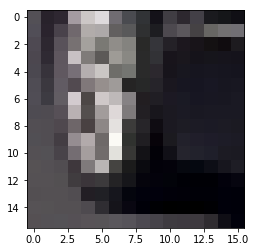

array([[ 0.99998367]], dtype=float32)

In [13]:
img2= mpimg.imread('training/vehicles/JWD_vcells/3.PNG')
plt.imshow(img2)
plt.show()
model.predict( np.array( preparePatch ( img2) ).reshape((1,-1)) )

In [27]:
x= np.linspace(0, 14, 15)
y=np.array([766,780,796,814,834,857,882,910,941,976,1014,1057,1103,1155,1214])
coefs1= np.polyfit(x,y,3)
y=np.array([411,410,410,409,409,408,407,406,406,405,403,402,401,398,397])
coefs2= np.polyfit(x,y,2)
y=np.array([14,16,18,20,23,25,28,31,35,38,43,46,52,59,66])
coefs3= np.polyfit(x,y,2)
def transformIdxToScreen(idxFloat):
    global coefs1, coefs2, coefs3
    f1= np.poly1d(coefs1)
    f2= np.poly1d(coefs2)
    f3= np.poly1d(coefs3)
    return f1(idxFloat), f2(idxFloat), f3(idxFloat)

In [28]:
print(transformIdxToScreen(12.256))

(1116.8249440186175, 399.94367824175868, 54.439370414996773)


In [121]:
x= np.linspace(0, 14, 15)
y=np.array([766,780,796,814,834,857,882,910,941,976,1014,1057,1103,1155,1214])
coefs1= np.polyfit(x,y,3)
print(coefs1)

[  5.02765209e-02   5.67496229e-01   1.41637399e+01   7.65433333e+02]


In [19]:
x= np.linspace(0, 14, 15)
y=np.array([14,16,18,20,23,25,28,31,35,38,43,46,52,59,66])
coefs2= np.polyfit(x,y,2)
print(coefs2)

[  0.17946025   1.01969942  14.98529412]


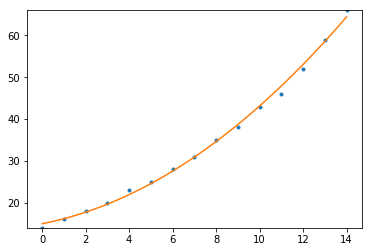

In [20]:
f= np.poly1d(coefs2)
xp = np.linspace(0, 14, 100)
_= plt.plot(x, y, '.', xp, f(xp), '-')
_=plt.ylim(14,66)
_=plt.figure( figsize=(16,9) )
plt.show()

In [24]:
y=np.array([411,410,410,409,409,408,407,406,406,405,403,402,401,398,397])
coefs3= np.polyfit(x,y,2)
print(coefs3)

[ -5.49450549e-02  -1.87912088e-01   4.10500000e+02]


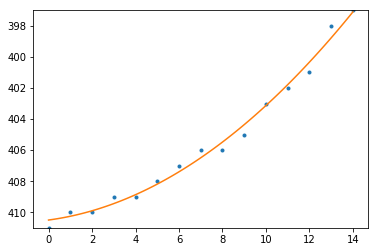

In [25]:
f= np.poly1d(coefs3)
xp = np.linspace(0, 14, 100)
_= plt.plot(x, y, '.', xp, f(xp), '-')
_=plt.ylim(411,397)
_=plt.figure( figsize=(16,9) )
plt.show()

In [132]:
#_______________________________________________________________________________
# Vehicle tracking class

class Vehicle():
    def __init__(self, color, left,top, width,height):
        self.color= color
        self.left= left
        self.top= top
        self.width= width
        self.height= height
        self.dx= 0  # relative speed (computed over frames)
        self.dy= 0
        self.refQ= NQ(4,(0,1))   #4 frames containing an array of refdata
        self.centroidX= left+width/2
        self.centroidY= top+height/2
        
    def updateCentroid(self):  #based on reference queue
        #zip through the queue and update location of centroid
        for i in range(len(self.refQ)):
            pass #  data= self.refQ.peek()
        lastX= self.centroidX
        lastY= self.centroidY
        self.centroidX= left+width/2
        self.centroidY= top+height/2
        #also update dx,dy
        self.dx= self.centroidX-lastX
        self.dy= self.centroidY-lastY
    
    #Resolve real-world patches to vehicle model
    #Patch affinity rules:
    #majority should be of one color (with darker lower on the image)
    #if occluded, patches belong to top vehicle
    def addReferenceData(self, dataList):  #dataList: [ [x,y,s,color], ... ]
        #reject/accept data according to rule set
        #modify dataList here
        #majority should be within a 'normal' range wrt distance (either computed or ascertained over time)
        # with consideration for dx,dy
        #if black car, reject white cells
        
        #add resulting data to queue
        self.refQ.put([ dataList ])
    
    def draw(self):
        global diagScreen
        pass # draw something to the screen
        #first, try just the centroid, or the bounding ellipse
        diagScreen[y:y+s-1, x:x+s-1, 2]= 255  # blue

# Example init for 'Black' video
carWhite= Vehicle('White', 862,415, 88,52)
carBlack= Vehicle('Black', 1233,394, 576,343) #width,height is apx (offscreen)



Contains majority white: False


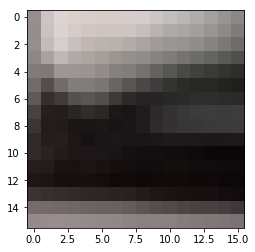

In [20]:
# Predominant color assessment
def dominantWhite(img): 
    return (img>90).sum() > (img<=90).sum()

img2= cv2.imread('training/vehicles/JWD_vcells/700.PNG')
print('Contains majority white:',dominantWhite(img2))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()


In [31]:
image= cv2.imread('analysis/vlcsnap-00020.png')
v1= image[401:401+158, 924:924+269]
mask= cv2.inRange(v1, np.array([60,60,60]), np.array([255,255,255]) )
output= cv2.bitwise_and(v1, v1, mask= mask)
cv2.imshow("image", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [30]:
cv2.destroyAllWindows()

In [27]:
image= cv2.imread('analysis/vlcsnap-00019.png')
v1= image[389:389+134, 1014:1014+266]
mask= cv2.inRange(v1, np.array([140,140,140]), np.array([255,255,255]) )
output= cv2.bitwise_and(v1, v1, mask= mask)
cv2.imshow("image", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


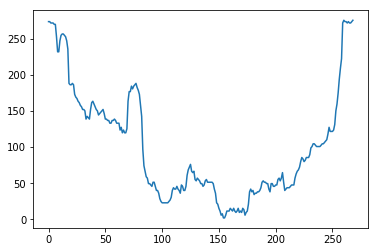

In [50]:
plt.plot(np.sum(mask/134, axis=0))
plt.show()

In [47]:
np.argmax(np.sum(mask/134, axis=0))

121

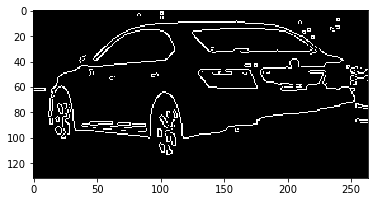

In [52]:
image= cv2.imread('analysis/WhiteTheshold-140.png')
edges= cv2.Canny(image,127,255)
plt.imshow(edges,cmap = 'gray')
plt.show()

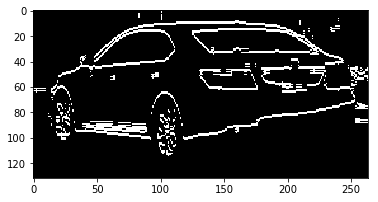

In [68]:
def sobelY(img, threshL=20, threshU=100):
    sobely= cv2.Sobel(img, cv2.CV_16S, 0, 1) # run the derivative in y
    abs_sobely= np.absolute(sobely) # absolute y derivative to accentuate horizontal lines 
    scaled_sobel= np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary= np.zeros_like(img)
    binary[(scaled_sobel >threshL) & (scaled_sobel <= threshU)]= 255 # threshold y gradient
    return binary
image= cv2.imread('analysis/WhiteTheshold-140.png')
edges= sobelY(image,127,255)
plt.imshow(edges,cmap = 'gray')
plt.show()

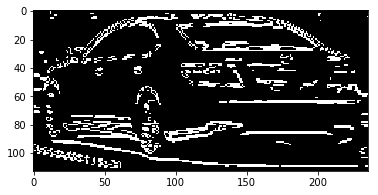

In [81]:
image= cv2.imread('analysis/Vehicle1.PNG')
edges= sobelY(cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,1],200,255)
plt.imshow(edges,cmap = 'gray')
plt.show()

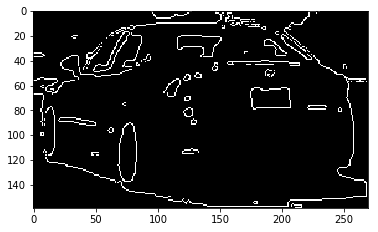

In [53]:
image= cv2.imread('analysis/BlackTheshold-60.png')
edges= cv2.Canny(image,127,255)
plt.imshow(edges,cmap = 'gray')
plt.show()


In [62]:
# Find centroid
lst= [ [0,0,0,0,0,0,0,0,0,0,1,1,1,1,0],
       [0,0,0,0,0,0,0,0,0,1,1,0,1,1,1],
       [0,0,0,0,0,0,0,0,1,0,1,1,0,1,1],
       [0,0,0,0,0,0,0,0,1,0,0,1,0,0,0] ]
n= 0
Xc= 0
Yc= 0
for y in range(0,len(lst)):
    for x in range(0,len(lst[0])):
        if lst[y][x]==1:
            Xc+= x
            Yc+= y
            n+= 1
Yc/= n
Xc/= n
print(Xc,Yc)

11.1875 1.3125


In [2]:
# Find centroid
lst= [ [0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,0,1,0,1,1,1,1,0,0,0],
       [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0] ]
count= 0
Xc= 0
Yc= 0
for y in range(0,len(lst)):
    for x in range(0,len(lst[0])):
        if lst[y][x]==1:
            Xc+= x
            Yc+= y
            count+= 1
Yc/= count
Xc/= count
print(Xc,Yc)

8.428571428571429 1.2142857142857142


In [8]:
m= cv2.moments(np.array(lst),True)
print(m['m10']/m['m00'], m['m01']/m['m00'])

8.428571428571429 1.2142857142857142


In [13]:
lst= [ [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
       [0,0,0,0,0,0,1,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
m= cv2.moments(np.array(lst),True)
print(m['m10']/m['m00'], m['m01']/m['m00'])

8.0 2.125


In [88]:
def locateCentroid(twoDimArray):
    m= cv2.moments(np.array(twoDimArray),True)
    return m['m10']/m['m00'], m['m01']/m['m00']
lst= [ [0,0,0,0,0,1,1,1,1,0,1,1,0,0,1],
       [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
       [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
print(locateCentroid(lst))

(8.481481481481481, 1.4814814814814814)


In [ ]:
previousCenter

In [110]:
# Attempt to remove noise (the '1' in the upper-right corner)
lst2= cv2.fastNlMeansDenoising(np.array(lst,dtype=np.uint8)*255, None,90,2,5)
print( lst2 )
lst3= np.array(lst2 > 200,dtype=np.uint8)
print( lst3 )
 

[[  0   0   0   1   8 233 217 228 214 118 230 238  18   3 196]
 [  0   0   0   1   9 238  81 231 233 244 233 238  18   6 140]
 [  0   0   0   1  10 235 215 232 119 234 211 238  17   7  36]
 [  0   0   0   1   9 224 170 228 237 245 224 239  17  13  12]]
[[0 0 0 0 0 1 1 1 1 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 0 1 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]]


In [111]:
print(locateCentroid(lst3))

(8.125, 1.5)


In [9]:
lst= [ [0,0,0,0,0,0,1,1,1,0,1,0,0,0,1],
       [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
       [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]

tst1= np.zeros_like(lst)
print(tst1)
cv2.ellipse(tst1, ((14,2), (7,4),0), 1,-1)
print(tst1)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]]


In [12]:
lst4= cv2.bitwise_and(tst1, np.array(lst))
print( lst4 )

[[0 0 0 0 0 0 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 0 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 0 0 0]]


In [136]:
print(locateCentroid(lst4))

(8.043478260869565, 1.6956521739130435)


In [21]:
def locateCentroid(twoDimArray, prevCenterTuple):
    mask= np.zeros_like(lst)
    cv2.ellipse(mask, (prevCenterTuple, (7,4),0), 1,-1)
    masked= cv2.bitwise_and(mask, np.array(twoDimArray))
    m= cv2.moments(np.array(masked),True)
    return m['m10']/m['m00'], m['m01']/m['m00']
lst= [ [0,0,0,0,0,1,1,1,1,0,1,1,0,0,1],
       [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
       [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
print( locateCentroid(lst, (8.5,1.5)) )

(8.166666666666666, 1.625)


In [145]:
# Python implementation of HOG based on OpenCV
def histoGrad(img, binCount=12, cellSize=4, fname='fault'):
    gx= cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy= cv2.Sobel(img, cv2.CV_32F, 0, 1)
    magnitude,angle= cv2.cartToPolar(gx,gy)
    bins= np.int32(binCount*angle*(1-1e-7)/(2*np.pi))
    print(angle)
    binCells, magCells= [], []
    cx= cy= cellSize
    for i in range(0,int(img.shape[0]/cy)):
        for j in range(0,int(img.shape[1]/cx)):
            binCells.append(bins[i*cy:i*cy+cy, j*cx:j*cx+cx])
            magCells.append(magnitude[i*cy:i*cy+cy, j*cx:j*cx+cx])
    #print(len(binCells), len(magCells))
    #print(list(zip(binCells, magCells)))
    hists= [np.bincount(i.ravel(), j.ravel(), binCount) for i,j in zip(binCells, magCells)]
    #print(hists)
    hist= np.hstack(hists)
    if len(hist)==193:
        hist= hist[0:192]
        print(fname)
    hist/= hist.sum()+1e-8 # apply Hellinger kernel (L1-normalize and sqrt)
    hist= np.sqrt(hist)
    return hist

img2= cv2.imread('training/vehicles/JWD_vcells/700.PNG')
#print( histoGrad(img2[:,:,0])[:10] )
myhist= histoGrad(img2[:,:,0])

#[ 0.09165663  0.          0.          0.          0.          0.       0.03250726  0.07824319  0.07127868  0.12797922]
#[ 0.09165664  0.          0.          0.          0.          0.       0.03250726  0.0782432   0.07127869  0.12797923]

[[ 0.          0.          0.          3.14159274  3.14159274  3.14159274
   0.          3.14159274  3.14159274  3.14159274  3.14159274  3.14159274
   3.14159274  3.14159274  3.14159274  0.        ]
 [ 4.71238899  6.18719912  5.44392872  3.97764516  4.37002087  4.60391951
   4.65160561  4.54606247  4.3905735   4.32352448  4.40216064  4.38202333
   4.18386459  4.05508327  3.99474263  4.71238899]
 [ 4.71238899  5.89623213  4.9416399   4.15816498  4.39496088  4.50773954
   4.55149508  4.5316906   4.43789816  4.41205215  4.49315739  4.48998308
   4.39644098  4.3301158   4.28186178  4.71238899]
 [ 4.71238899  5.43676472  4.93723869  4.36754322  4.42903376  4.35820055
   4.43404484  4.49093485  4.39929771  4.41892958  4.49052238  4.50454092
   4.49613857  4.47375584  4.45219994  4.71238899]
 [ 4.71238899  5.05407667  5.09052467  4.65981579  4.49246025  4.29191589
   4.33813953  4.4277091   4.3746233   4.39486694  4.44318199  4.47800112
   4.5250206   4.50698566  4.46738338  4.71238899]
 [ 4.

In [15]:
sum(histoGrad(img2[:,:,0]))

0.999999999997


5.9515730336235935

In [18]:
sum(histoGrad(img2[:,:,0]))

5.9515724384742112

In [156]:
hist= np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
#hist /= hist.sum() + 1e-7
print (hist/(hist.sum() + 1e-7))
hist= np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
hist /= (hist.sum() + 1e-7) 
print (hist)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [45]:
print( (i,j) for i,j in zip(hist))

<generator object <genexpr> at 0x000001994148CBA0>


In [142]:
vimages = glob.glob('training/vehicles/JWD_vcells/*.png')
for image in vimages:
    img2= mpimg.imread(image)
    fimage= cv2.cvtColor(img2, cv2.COLOR_RGB2YCrCb)
    for channel in range(fimage.shape[2]):
        myhist= histoGrad(fimage[:,:,channel], fname=image)

In [143]:
img2= mpimg.imread('training/vehicles/JWD_vcells/61-1014-532.PNG')
fimage= cv2.cvtColor(img2, cv2.COLOR_RGB2YCrCb)
print(fimage.shape)

(16, 16, 3)


In [146]:
print(fimage[0,0])
for channel in range(fimage.shape[2]):
    myhist= histoGrad(fimage[:,:,channel])

[ 0.0728      0.50401515  0.52087021]
[[ 0.          3.14159274  3.14159274  3.14159274  3.14159274  3.14159274
   3.14159274  3.14159274  3.14159274  0.          0.          3.14159274
   0.          0.          0.          0.        ]
 [ 1.57079637  2.1042695   1.94992685  1.68124735  1.71910226  1.82815325
   1.74546528  1.88378215  1.89191985  0.78643435  1.11066616  1.91922379
   1.12646139  0.60441834  0.57090032  1.57079637]
 [ 4.71238899  0.68446016  1.38967907  1.67150486  1.77808666  1.97576177
   2.00748181  2.0276618   1.91704881  1.22373843  1.02419317  1.48820281
   1.31441915  0.63171071  6.26012754  4.71238899]
 [ 4.71238899  5.34571218  5.37373829  5.68765926  1.09125829  1.48875332
   1.64409125  1.62946701  1.61827826  1.51362181  1.40500379  1.48031664
   1.6212647   1.75829995  2.98289084  4.71238899]
 [ 4.71238899  5.12962437  4.99639034  5.0162406   5.57970333  0.11236435
   1.18258107  1.42924666  1.55103827  1.5924226   1.59479713  1.86734784
   3.09488797  3.6

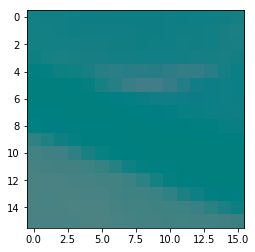

In [100]:
plt.imshow(fimage)
plt.show()

In [119]:
x=[np.array([ 0.        ,  0.05740977,  0.10981189,  0.26433566,  0.02732746,
        0.        ,  0.07629805,  0.        ,  0.        ,  0.25484702,
        0.40318589,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.4209156 ,  1.34009632,  0.        ,
        0.        ,  0.04164705,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.03746666,  0.09320346,  1.48847115,  0.51790471,  0.        ,
        0.        ,  0.02386666,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.23512159,  0.40555992,  0.14375959,  0.86044762,  0.        ,
        0.10582807,  0.        ,  0.        ,  0.        ,  0.17856467,
        0.        ,  0.08876871]), 
   np.array([ 0.00442134,  0.00489744,  0.        ,  0.07923554,  0.        ,
        0.00841992,  0.        ,  0.        ,  0.        ,  2.09209207,
        0.03578462,  0.        ]), 
   np.array([  2.37060040e-01,   0.00000000e+00,   8.91748637e-01,
         0.00000000e+00,   1.28676475e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.83230358e+00,   1.12357363e+00,   6.97881635e-03]), 
   np.array([ 0.        ,  0.        ,  0.68445921,  1.41112117,  0.        ,
        0.        ,  0.        ,  0.        ,  2.6818729 ,  3.24909534,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.00583707,  0.        ,  0.03192943,  0.        ,
        0.1604849 ,  0.253647  ,  0.50664485,  1.28004704,  0.76066794,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.        ,  8.91285907,  0.120569  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,                   # <------------- problem 13 elements
         7.04978541e+00,   1.00795419e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.20356176e-02,   0.00000000e+00,
         2.34509818e-03]), 
   np.array([ 0.        ,  0.        ,  0.        ,  1.09371275,  0.34154844,
        0.        ,  0.00534421,  0.00453217,  0.        ,  0.2677984 ,
        0.        ,  0.        ]), 
   np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.13772310e-02,   6.32236712e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.10250153e+00,   4.47058864e-03,   4.22893511e-03]), 
   np.array([ 0.10107597,  0.        ,  0.05127015,  0.40661669,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.01568627,
        0.        ,  0.01182166]), 
   np.array([ 0.03316075,  0.        ,  0.05051671,  1.99566305,  0.86572638,
        0.        ,  0.29019606,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.        ,  7.116294  ,  0.2499977 ,
        0.        ,  0.14447051,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.        ,  6.46936287,  0.02923101,
        0.        ,  0.68200797,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])]


In [124]:
for i in x: print(i.shape)

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(13,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


In [ ]:
[(array([[ 0,  6,  6,  6],
       [ 3,  4,  3,  3],
       [ 9,  1,  2,  3],
       [ 9, 10, 10, 10]]), array([[ 0.        ,  0.02174118,  0.03827452,  0.01628235],
       [ 0.01568627,  0.02732746,  0.05361361,  0.07655288],
       [ 0.01423526,  0.05740977,  0.10981189,  0.1184829 ],
       [ 0.24061176,  0.24008824,  0.13351713,  0.02958052]], dtype=float32)), 
 
 (array([[6, 6, 6, 6],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [2, 2, 3, 3]]), array([[ 0.00938038,  0.01568627,  0.00784314,  0.00873726],
       [ 0.08208155,  0.0770466 ,  0.06769677,  0.05676446],
       [ 0.10253605,  0.08959732,  0.0649135 ,  0.05473847],
       [ 0.13724345,  0.28367215,  0.3663919 ,  0.37832969]], dtype=float32)), 
 
 (array([[6, 0, 0, 6],
       [3, 1, 2, 3],
       [3, 2, 1, 2],
       [3, 2, 2, 2]]), array([[ 0.00460392,  0.02953725,  0.00792941,  0.01926274],
       [ 0.03944292,  0.03752382,  0.03451458,  0.04494255],
       [ 0.05584636,  0.05062494,  0.05567963,  0.07133739],
       [ 0.37767288,  0.38883558,  0.44360083,  0.49955782]], dtype=float32)), 
 
 (array([[ 0,  0,  0,  0],
       [ 2,  1,  1,  3],
       [ 2,  1, 11,  9],
       [ 3,  3,  5,  9]]), array([[ 0.02174118,  0.07689411,  0.13648629,  0.        ],
       [ 0.0516234 ,  0.11729055,  0.16688228,  0.09411764],
       [ 0.09213619,  0.12138709,  0.08876871,  0.05763131],
       [ 0.47215828,  0.29417169,  0.10582807,  0.12093335]], dtype=float32)), 
 
 (array([[ 9,  9,  9,  9],
       [ 9,  9,  9,  9],
       [ 3,  1,  0, 10],
       [ 3,  3,  3,  5]]), array([[ 0.27607062,  0.35264665,  0.39657491,  0.37088957],
       [ 0.05932549,  0.11735339,  0.20672254,  0.31250888],
       [ 0.00357647,  0.00489744,  0.00442134,  0.03578462],
       [ 0.03758431,  0.027342  ,  0.01073275,  0.00841992]], dtype=float32)), 
 
 (array([[10,  0,  2,  2],
       [10,  9,  9,  9],
       [10,  9,  9,  9],
       [ 4, 11, 10, 10]]), array([[ 0.33283666,  0.23706004,  0.33453956,  0.55720907],
       [ 0.50829172,  0.65860367,  0.68256879,  0.61124712],
       [ 0.17243633,  0.38790631,  0.63679415,  0.85518354],
       [ 0.00128676,  0.00697882,  0.03109698,  0.07891195]], dtype=float32)), 
 
 (array([[2, 3, 3, 3],
       [9, 8, 8, 8],
       [9, 9, 8, 8],
       [9, 9, 9, 9]]), array([[ 0.68445921,  0.66830552,  0.49715114,  0.24566452],
       [ 0.48195171,  0.40111613,  0.48039362,  0.59560531],
       [ 0.96867365,  0.92936027,  0.74235708,  0.46240076],
       [ 0.1577282 ,  0.23756211,  0.25679493,  0.21702448]], dtype=float32)), 
 
 (array([[5, 6, 7, 9],
       [8, 8, 7, 9],
       [8, 8, 1, 3],
       [9, 9, 9, 9]]), array([[ 0.1604849 ,  0.253647  ,  0.28701279,  0.15370986],
       [ 0.58296067,  0.42245543,  0.21963206,  0.06453332],
       [ 0.21087   ,  0.06376095,  0.00583707,  0.03192943],
       [ 0.17498916,  0.15524548,  0.12481757,  0.08737254]], dtype=float32)), 
 
 (array([[3, 3, 3, 4],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3]]), array([[ 0.60536474,  0.50397444,  0.28190112,  0.120569  ],
       [ 0.97370195,  1.00792253,  0.94982421,  0.75806338],
       [ 0.47865105,  0.60567427,  0.82023215,  0.99120826],
       [ 0.12839222,  0.14606726,  0.22485779,  0.4370237 ]], dtype=float32)), 
 
 (array([[ 4,  3, 12, 10],        # <-----------------------------problem: contains a '12', perhaps should be a '0'
       [ 3,  3,  4,  4],
       [ 3,  3,  3,  3],
       [ 3,  3,  3,  3]]), array([[ 0.02867608,  0.00757599,  0.0023451 ,  0.01203562],
       [ 0.45559615,  0.19863945,  0.06144724,  0.0106721 ],
       [ 0.99970371,  0.84381515,  0.58655256,  0.31106469],
       [ 0.71954715,  0.93420213,  1.03178489,  0.96130353]], dtype=float32)), 
 
 (array([[9, 9, 9, 9],
       [7, 6, 9, 9],
       [4, 4, 3, 4],
       [3, 3, 4, 4]]), array([[ 0.01732321,  0.03125613,  0.07196216,  0.12406516],
       [ 0.00453217,  0.00534421,  0.00632237,  0.01686938],
       [ 0.1123475 ,  0.03213956,  0.01320437,  0.00587951],
       [ 0.69865966,  0.38184872,  0.15075047,  0.0404314 ]], dtype=float32)), 
 
 (array([[ 9,  9,  9,  9],
       [ 9,  9,  9,  9],
       [ 4, 11, 10,  9],
       [ 3,  3,  9,  9]]), array([[ 0.15952474,  0.18842112,  0.21819153,  0.21976472],
       [ 0.03034863,  0.05676152,  0.09881474,  0.1197255 ],
       [ 0.00063224,  0.00422894,  0.00447059,  0.00536471],
       [ 0.00909767,  0.00227956,  0.0023451 ,  0.00323922]], dtype=float32)),
 
 (array([[ 3,  3,  3,  3],
       [ 3,  3,  3,  2],
       [ 9,  9, 11,  0],
       [ 0,  0,  0,  0]]), array([[ 0.0604862 ,  0.07706217,  0.10225552,  0.12813143],
       [ 0.00694895,  0.00770867,  0.02402374,  0.05127015],
       [ 0.00784314,  0.00784314,  0.01182166,  0.03687986],
       [ 0.        ,  0.        ,  0.01624316,  0.04795295]], dtype=float32)), 
 
 (array([[3, 3, 3, 3],
       [3, 4, 4, 4],
       [2, 4, 4, 4],
       [0, 6, 6, 6]]), array([[ 0.20926023,  0.34821457,  0.54736716,  0.80205852],
       [ 0.08876258,  0.13516083,  0.15145583,  0.20371996],
       [ 0.05051671,  0.10531563,  0.1573928 ,  0.11268132],
       [ 0.03316075,  0.07058823,  0.12549019,  0.09411764]], dtype=float32)), 
 
 (array([[3, 3, 3, 3],
       [3, 3, 3, 3],
       [4, 4, 3, 3],
       [6, 6, 6, 6]]), array([[ 0.96679169,  0.9414643 ,  0.76208103,  0.49247956],
       [ 0.42901075,  0.71234769,  0.91504472,  0.97472161],
       [ 0.08866442,  0.16133328,  0.33183768,  0.59051496],
       [ 0.03832155,  0.03887841,  0.03201565,  0.0352549 ]], dtype=float32)), 
 
 (array([[3, 3, 4, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [6, 6, 6, 0]]), array([[ 0.24282601,  0.09512889,  0.02923101,  0.01141961],
       [ 0.88638353,  0.69486117,  0.45160782,  0.30527845],
       [ 0.84017599,  0.98397762,  1.00596261,  0.95174116],
       [ 0.13576481,  0.24914515,  0.29709801,  0.        ]], dtype=float32))]

In [137]:
print(np.int32(12*6.28318548/(2*np.pi)))

12


In [149]:
12*2*np.pi*(1-1e-7)/(2*np.pi)

11.9999988

In [153]:
np.int32(12*2*np.pi*(1-1e-7)/(2*np.pi))

11

In [24]:
class NQ():
    def __init__(self,qlen,shape,dtype=np.uint8):
        self.data= np.empty(shape=shape,dtype=dtype)
        self.qlen= qlen
    def put(self,a):
        self.data= np.append(self.data,a, axis=0)
        if len(self.data)>self.qlen: self.drop()
    def peek(self):
        return self.data[len(self.data)-1]
    def drop(self):
        self.data= np.delete(self.data, 0, axis=0)
    def getAvg(self):
        newList= np.copy(self.data[0])
        newList[:]= np.sum(self.data[:], axis=0)/float(len(self.data))
        return newList

centerQ= NQ(4,(0,2),np.float)
c= (15.,2.)
centerQ.put([ np.array(c) ])
c= (17.,4.)


In [26]:
centerQ.put([ np.array(c) ])
centerQ.getAvg()

array([ 16.,   3.])

[[ 438.0000002   28.       ]
 [ 192.0000002   41.       ]
 [  20.         155.       ]
 [  20.         258.       ]
 [ 302.         371.       ]
 [ 620.         353.       ]
 [ 620.         152.       ]]


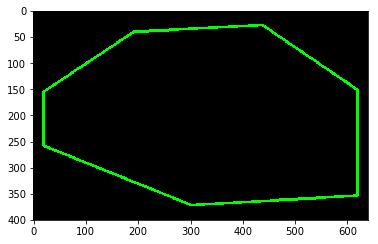

In [41]:
pts=np.array([[0.696666667,0.07],
[0.286666667,0.1025],
[0,0.3875],
[0,0.645],
[0.47,0.9275],
[1,0.8825],
[1,0.38]])
pts[:,0]= pts[:,0]*600 + 20
pts[:,1]*=400 
print(pts)
img= np.zeros(shape=(400,640,3),dtype=np.uint8)
p= cv2.polylines(img, [pts.astype(np.int32)], True, (0,255,0), 3)
plt.imshow(p)
plt.show()

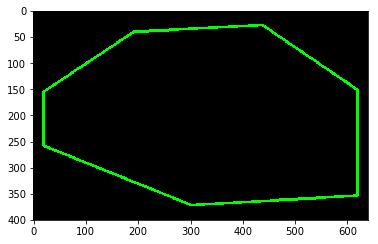

In [47]:
def renderRig(img, cx,cy, width,height, clr, strokeWeight):
    pts=np.array([[0.696666667,0.07], [0.286666667,0.1025], [0,0.3875], [0,0.645], [0.47,0.9275], [1,0.8825], [1,0.38]])
    pts[:,0]= pts[:,0]*width  + cx-width //2
    pts[:,1]= pts[:,1]*height + cy-height//2
    #print(pts)
    p= cv2.polylines(img, [pts.astype(np.int32)], True, clr, strokeWeight)
    return p

imgX= np.zeros(shape=(400,640,3),dtype=np.uint8)
p= renderRig(imgX, 320,200, 600,400, (0,255,0), 3)
plt.imshow(p)
plt.show()

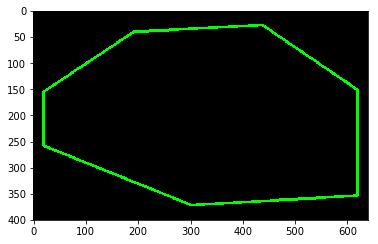

In [48]:
def renderRig(img, cx,cy, width,height, clr, strokeWeight):
    pts=np.array([[0.696666667,0.07], [0.286666667,0.1025], [0,0.3875], [0,0.645], [0.47,0.9275], [1,0.8825], [1,0.38]])
    pts[:,0]= pts[:,0]*width  + cx-width //2
    pts[:,1]= pts[:,1]*height + cy-height//2
    cv2.polylines(img, [pts.astype(np.int32)], True, clr, strokeWeight)

imgX= np.zeros(shape=(400,640,3),dtype=np.uint8)
renderRig(imgX, 320,200, 600,400, (0,255,0), 3)
plt.imshow(imgX)
plt.show()

In [50]:
x,y= centroidQ.getAvg()

In [51]:
print(x,y)

875 458
